# Text classification

Example of a many-to-one problem using recurrent neural network. Following this [tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

Let's try just like that.

Required tasks:

- load data
- vectorize using one-hot encoding
- write network class
- setup training
- train

Next: 
- Implement a test set and test function

Note that the same name can be present in multiple languages. Therefore, cross correlation loss is not really adapted.

In [1]:
# imports
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import pandas
import glob
import re
import string
import unicodedata
import matplotlib.pyplot as plt
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s, vocabulary):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in vocabulary
    )

# Preprocessing
## Create dictionaries that map language->name and name->language

Certain files contain a lot of non-unique names. For example the "Arabic.txt" file contains 2000 lines but only 108 unique names. Here, we keep only the unique names. Note that the same name can appear in several languages. First, that means we can never achieve 100% accuracy. Second, we cannot store the examples as a name to language dictionary. Instead I'll use to lists: one for names and one for language.

In [267]:
file_list = glob.glob("./Data/names/names/*")
languages = [re.findall(r'./Data/names/names/(.*)\.txt',t)[0] for t in file_list]
lang2name = {}
name2lang = {}
# vocabulary = string.ascii_letters + " .,;-'"
vocabulary = string.ascii_lowercase + " .,;'"

max_seq_length = 0
name_list = []
lang_list = []
for lang, filename in zip(languages,file_list):
    with open(filename) as file:
        names = [l[:-1] for l in file.readlines()]
        names = list(set(names))
        names = [unicode_to_ascii(n.lower(), vocabulary) for n in names]
        lang2name[lang] = names
        name_list += names
        lang_list += [lang]*len(names)
        for n in names:
            max_seq_length = max(max_seq_length,len(n))

In [268]:
# len()for key in lang2name.keys()
total_names = 0
lang2weights = {}
for k, v in lang2name.items():
    print(k, len(v),  1.0/(len(v)))
    total_names += len(v)
    lang2weights[k] = 1.0/len(v)

# Check that every class is weighted equally
total_weights = {}
for k, v in lang2weights.items(): # init
    total_weights[k] = 0

count = 0    
for name, lang in zip(name_list, lang_list):
    total_weights[lang] += lang2weights[lang]
    count += 1
total_weights

Czech 503 0.0019880715705765406
German 706 0.00141643059490085
Arabic 108 0.009259259259259259
Japanese 990 0.00101010101010101
Chinese 246 0.0040650406504065045
Vietnamese 71 0.014084507042253521
Russian 9342 0.00010704345964461572
French 273 0.003663003663003663
Irish 226 0.004424778761061947
English 3668 0.0002726281352235551
Spanish 296 0.0033783783783783786
Greek 193 0.0051813471502590676
Italian 701 0.0014265335235378032
Portuguese 74 0.013513513513513514
Scottish 100 0.01
Dutch 286 0.0034965034965034965
Korean 94 0.010638297872340425
Polish 138 0.007246376811594203


{'Czech': 1.0000000000000093,
 'German': 0.9999999999999932,
 'Arabic': 1.0000000000000016,
 'Japanese': 1.000000000000006,
 'Chinese': 0.999999999999997,
 'Vietnamese': 0.9999999999999991,
 'Russian': 1.0000000000001081,
 'French': 0.999999999999997,
 'Irish': 1.0000000000000013,
 'English': 0.9999999999999883,
 'Spanish': 1.0000000000000042,
 'Greek': 1.0000000000000024,
 'Italian': 1.0000000000000053,
 'Portuguese': 0.9999999999999986,
 'Scottish': 1.0000000000000007,
 'Dutch': 1.0000000000000062,
 'Korean': 0.9999999999999983,
 'Polish': 1.0000000000000013}

In [269]:
len(set(lang2name['Arabic']))

108

# Dataset class

In [270]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, seq_list, cat_list, vocabulary, categories, max_seq_length):
        # seq2cat (dict) mapping input sequence and output category
        super(MyDataset,self).__init__()
        self.input_sequences = seq_list#list(seq2cat.keys())
        self.output_category =  cat_list#list(seq2cat.values())
        self.categories = categories
        self.vocabulary = vocabulary
        self.max_seq_length = max_seq_length
        
        self.vocab_length = len(self.vocabulary)
        self.vocab2vec = {}
        for i, vocab in enumerate(self.vocabulary):
            self.vocab2vec[vocab] = torch.zeros((1,self.vocab_length),dtype=torch.float32)
            self.vocab2vec[vocab][0,i] = 1
            
        num_categories = len(categories)
        self.cat2vec = {}
        for i, cat in enumerate(categories):
            self.cat2vec[cat] = torch.tensor(i,dtype=torch.long)
            
            
        
    def __len__(self):
        return len(self.input_sequences)
    
    def _get_seq_vec(self,sequence):
        # Pad 
        out = torch.zeros((self.max_seq_length,self.vocab_length))
        for i, vec in enumerate(sequence.lower()):
            out[i,:] = self.vocab2vec[vec]
        return out
#         Don't pad
#         return torch.cat([self.vocab2vec[vec] for vec in sequence.lower()],axis=0)
#         return torch.cat([self.vocab2vec[vec] for vec in sequence],axis=0)
        
    
    
    def __getitem__(self, index):
#         print(self.input_sequences[index])
        input_sequence = self._get_seq_vec(self.input_sequences[index])
        output_category = self.cat2vec[self.output_category[index]]
        
#         print(input_sequence)
#         print(output_category.shape)
        
        return (input_sequence, output_category)
    
# Test    
dataset = MyDataset(name_list, lang_list, vocabulary, languages, max_seq_length)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=32, shuffle=True)
inp, cat = next(iter(dataloader))
inp[0].shape

torch.Size([19, 31])

# Define neural network

In [271]:
class MyRNN(nn.Module):
    def __init__(self,vocab_length, num_categories,num_layers=1,hidden_size=128):
        super(MyRNN,self).__init__()
        self.rnn = nn.RNN(input_size=vocab_length,
                     hidden_size=hidden_size,#num_categories,
                     num_layers=num_layers, batch_first=True, nonlinearity='relu')
        self.linear = nn.Linear(hidden_size,num_categories)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
#         self.rnn = nn.LSTM(input_size=vocab_length,
#                      hidden_size=num_categories,
#                      num_layers=1, batch_first=True)
#         self.linear = nn.Linear()
    def forward(self,X):
        # Pack padding to let the RNN know where to stop the sequence
        seq_len = X.sum(dim=2).sum(dim=1).int()
        X = torch.nn.utils.rnn.pack_padded_sequence(X,seq_len,batch_first=True, enforce_sorted=False)
#         cat_out = model(inp, seq_len[-1])
        
        out, H = self.rnn(X)
        out, out_len = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        
        out = torch.cat([out[sample,out_len[sample]-1,:].view(1,1,-1) for sample in range(out.shape[0])],dim=0)

#         out = out.view(out.shape[0],1,out.shape[1])
#         print(out.shape)
        out = self.linear(self.relu(out))

        return out.view(out.shape[0],out.shape[2])
    
# # Test  
# num_categories = len(languages)
# vocab_length = len(vocabulary)
# model = MyRNN(vocab_length, num_categories,1)
# dataset = MyDataset(name2lang, vocabulary, languages, max_seq_length)
# dataloader = torch.utils.data.DataLoader(dataset,batch_size=1, shuffle=True)
# inp = next(iter(dataloader))[0]
# out = model(inp)
# out.shape

In [272]:
# From PyTorch tutorial
class HisRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(HisRNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        # added
        self.tanh = nn.Tanh()
    def forward(self, input):
        hidden = torch.zeros(input.shape[0],self.hidden_size)
        for i in range(input.shape[1]):
            inp = input[:,i,:]
            combined = torch.cat((inp, hidden), 1)
            hidden = self.tanh(self.i2h(combined))
            output = self.i2o(combined)
#             output = self.softmax(output)

        return output[:,-1,:] # only works for non-padded sequences

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = HisRNN(vocab_length, n_hidden, num_categories)

In [273]:
# # Old
# class MyRNN(nn.Module):
#     def __init__(self,vocab_length, num_categories,num_layers=1):
#         super(MyRNN,self).__init__()
#         hidden_size = 128
#         self.rnn = nn.RNN(input_size=vocab_length,
#                      hidden_size=hidden_size,#num_categories,
#                      num_layers=num_layers, batch_first=True)
# #         self.rnn = nn.LSTM(input_size=vocab_length,
# #                      hidden_size=num_categories,
# #                      num_layers=1, batch_first=True)
# #         self.linear = nn.Linear()
#     def forward(self,X):
#         return self.rnn(X)
    

# Initialize training

In [279]:
num_categories = len(languages)
vocab_length = len(vocabulary)
model = MyRNN(vocab_length, num_categories,1)
# model = HisRNN(vocab_length, n_hidden, num_categories)
loss_fn = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(),lr=5e-3)
# optimizer = torch.optim.SGD(model.parameters(),lr=5e-3)
# dataset = MyDataset(name_list, lang_list, vocabulary, languages, max_seq_length)
dataset = MyDataset(name_list, lang_list, vocabulary, languages, max_seq_length)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=32, shuffle=True)
inp, cat = next(iter(dataloader))
# inp.shape
# cat.shape


# Train

The dataset is imbalanced (9342 Russian examples, only 74 Portuguese). If we just run train over all the examples in the dataset the model just learns to predict everything as the one or two classes with the most examples (Russian and English). To overcome this difficulty we can choose between several strategy:

- option 1: don't use a dataloader but iterate and choose one example per class at each iteration, or similarly, randomly sample a class and a sample from that class. That ensures that as many samples from each class is seen. The inconvenient is that samples from small classes are seen many times while samples for large classes are barely seen. This method is used [here](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) (see their randomTrainingExample function).
- option 2: subsampling, i.e. create a new dataset at each epoch which contains as many examples from each class (randomly chosen)
- option 3: use a dataloader (goes through every examples once per epoch) and weight the loss function according to the class, where the weight is $w=1/n_{class}$, where $n_{class}$ is the number of example in that class. I'll use this option here.

In [280]:
# optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
n_iter = len(dataloader)
for epoch in range(100):
    n_data = len(dataloader)
    loss_total = 0
    accuracy = 0
    for i, (inp, ground_truth) in enumerate(dataloader):
        optimizer.zero_grad()

        out = model(inp)


        loss = loss_fn(out, ground_truth)
        loss_total += loss.mean()

        loss *= torch.tensor([lang2weights[languages[gt]] for gt in ground_truth]) # Weighting to ensure each class carries as much in the loss calculation (fixes class imbalance)
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            pred = np.argmax(out,axis=1)
            accuracy += (pred == ground_truth).sum()/len(ground_truth)

    loss_total /= n_iter
    accuracy /= n_iter
    
    print(f"epoch {epoch:03d}: loss={loss_total:.2e}, accuracy={accuracy:.2e}")

epoch 000: loss=1.87e+00, accuracy=4.34e-01
epoch 001: loss=1.56e+00, accuracy=5.09e-01
epoch 002: loss=1.48e+00, accuracy=5.36e-01
epoch 003: loss=1.44e+00, accuracy=5.43e-01
epoch 004: loss=1.38e+00, accuracy=5.64e-01
epoch 005: loss=1.41e+00, accuracy=5.52e-01
epoch 006: loss=1.34e+00, accuracy=5.72e-01
epoch 007: loss=1.34e+00, accuracy=5.75e-01
epoch 008: loss=1.31e+00, accuracy=5.83e-01
epoch 009: loss=1.33e+00, accuracy=5.75e-01
epoch 010: loss=1.35e+00, accuracy=5.80e-01
epoch 011: loss=1.30e+00, accuracy=5.89e-01
epoch 012: loss=1.27e+00, accuracy=5.93e-01
epoch 013: loss=1.28e+00, accuracy=5.94e-01
epoch 014: loss=1.27e+00, accuracy=5.95e-01
epoch 015: loss=1.27e+00, accuracy=6.03e-01
epoch 016: loss=1.28e+00, accuracy=5.93e-01
epoch 017: loss=1.26e+00, accuracy=6.06e-01
epoch 018: loss=1.27e+00, accuracy=6.07e-01
epoch 019: loss=1.32e+00, accuracy=5.86e-01
epoch 020: loss=1.29e+00, accuracy=5.96e-01
epoch 021: loss=1.30e+00, accuracy=5.93e-01
epoch 022: loss=1.26e+00, accura

KeyboardInterrupt: 

# Confusion matrix

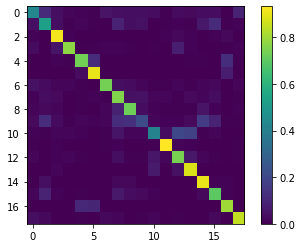

In [281]:
conf_mat = np.zeros((len(languages),len(languages)))
for i, (inp, ground_truth) in enumerate(dataloader):
#         seq_len = inp.sum(dim=2).sum(dim=1).int()
#         inp = torch.nn.utils.rnn.pack_padded_sequence(inp,seq_len,batch_first=True, enforce_sorted=False)
        out = model(inp)
        with torch.no_grad():
            pred = np.argmax(out,axis=1)
            for p, gt in zip(pred, ground_truth):
                conf_mat[gt,p] += 1.0
for i, l in enumerate(languages):
    conf_mat[i,:] /= np.sum(conf_mat[i,:])#len(lang2name[l])
    plt.imshow(conf_mat)      
plt.colorbar()